# Hunting for Exoplanets with AI - Experimental Suite

This notebook contains a comprehensive series of experiments to analyze Kepler data and train models for exoplanet detection.

## Table of Contents
1. **Data Exploration & Understanding**
2. **Data Quality & Preprocessing**
3. **Feature Engineering**
4. **Baseline Models**
5. **Advanced ML Models**
6. **Deep Learning Approaches**
7. **Ensemble Methods**
8. **Model Evaluation & Comparison**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Experiment 1: Data Exploration & Understanding

Understanding the Kepler dataset structure, target distribution, and key features.

In [2]:
# Load the Kepler dataset
data = pd.read_csv('data/input/kepler.csv', comment='#')

print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {data.shape[1]}")
print(f"Samples: {data.shape[0]}")
print("\nFirst few columns:")
print(data.columns[:20].tolist())

Dataset shape: (9564, 141)

Columns: 141
Samples: 9564

First few columns:
['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1']


Binary Classification Task (CANDIDATE excluded)

Target Variable Analysis (Original Dataset):

koi_disposition distribution:
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64

Percentages:
koi_disposition
FALSE POSITIVE    50.595985
CONFIRMED         28.711836
CANDIDATE         20.692179
Name: proportion, dtype: float64

CLASSIFICATION STRATEGY:
We will predict ONLY 2 classes (CANDIDATE excluded):
  • Class 0: FALSE POSITIVE
  • Class 1: CONFIRMED

CANDIDATE class is EXCLUDED from this analysis

Output: Probability distribution over 2 classes [P(FP), P(CONFIRMED)]
Example: [0.25, 0.75] = 25% FALSE POSITIVE, 75% CONFIRMED


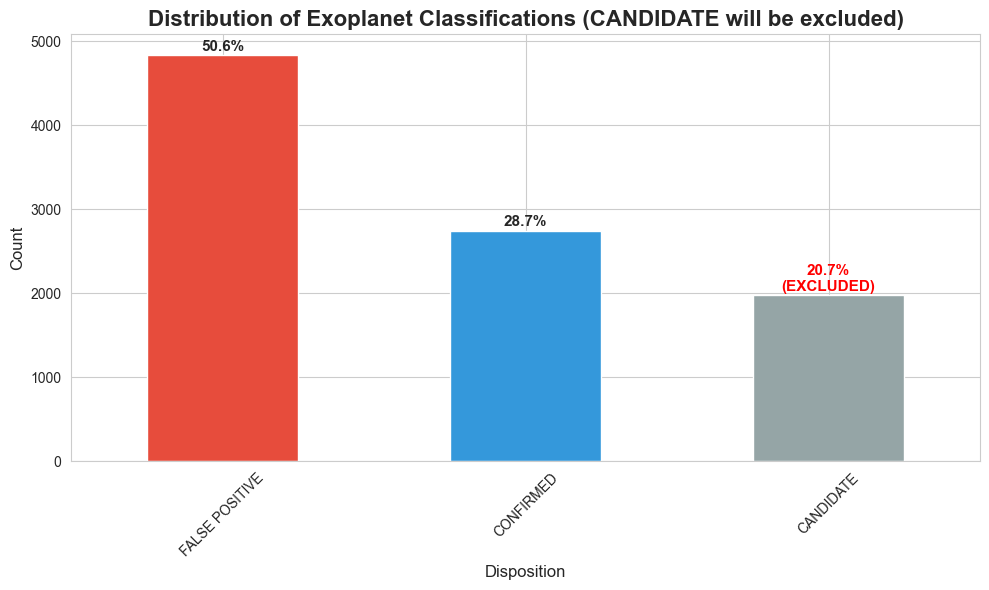

In [3]:
# Examine the target variable - disposition (Binary Classification: FALSE POSITIVE vs CONFIRMED)
print("Binary Classification Task (CANDIDATE excluded)")
print("=" * 80)
print("\nTarget Variable Analysis (Original Dataset):")
print("\nkoi_disposition distribution:")
print(data['koi_disposition'].value_counts())
print("\nPercentages:")
print(data['koi_disposition'].value_counts(normalize=True) * 100)

print("\n" + "=" * 80)
print("CLASSIFICATION STRATEGY:")
print("=" * 80)
print("We will predict ONLY 2 classes (CANDIDATE excluded):")
print("  • Class 0: FALSE POSITIVE")
print("  • Class 1: CONFIRMED")
print("\nCANDIDATE class is EXCLUDED from this analysis")
print("\nOutput: Probability distribution over 2 classes [P(FP), P(CONFIRMED)]")
print("Example: [0.25, 0.75] = 25% FALSE POSITIVE, 75% CONFIRMED")
print("=" * 80)

# Visualize target distribution (all 3 classes from original data)
plt.figure(figsize=(10, 6))
counts = data['koi_disposition'].value_counts()
colors_map = {'FALSE POSITIVE': '#e74c3c', 'CONFIRMED': '#3498db', 'CANDIDATE': '#95a5a6'}
colors = [colors_map[label] for label in counts.index]

counts.plot(kind='bar', color=colors)
plt.title('Distribution of Exoplanet Classifications (CANDIDATE will be excluded)', fontsize=16, fontweight='bold')
plt.xlabel('Disposition', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add percentage labels
for i, (label, count) in enumerate(counts.items()):
    pct = (count / counts.sum()) * 100
    if label == 'CANDIDATE':
        plt.text(i, count + 50, f'{pct:.1f}%\n(EXCLUDED)', ha='center', fontsize=11, fontweight='bold', color='red')
    else:
        plt.text(i, count + 50, f'{pct:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
# Data info and missing values
print("Dataset Info:")
print(data.info())
print("\n" + "="*80 + "\n")

# Missing values analysis
missing_pct = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

print(f"Columns with missing values: {len(missing_pct)}")
print("\nTop 20 columns with most missing data:")
print(missing_pct.head(20))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 141 entries, rowid to koi_dikco_msky_err
dtypes: float64(117), int64(7), object(17)
memory usage: 10.3+ MB
None


Columns with missing values: 120

Top 20 columns with most missing data:
koi_incl_err1       100.000000
koi_sma_err2        100.000000
koi_sma_err1        100.000000
koi_teq_err1        100.000000
koi_teq_err2        100.000000
koi_longp_err2      100.000000
koi_ingress         100.000000
koi_ingress_err2    100.000000
koi_ingress_err1    100.000000
koi_longp_err1      100.000000
koi_longp           100.000000
koi_eccen_err2      100.000000
koi_eccen_err1      100.000000
koi_sage_err1       100.000000
koi_sage_err2       100.000000
koi_sage            100.000000
koi_model_dof       100.000000
koi_model_chisq     100.000000
koi_incl_err2       100.000000
kepler_name          71.277708
dtype: float64


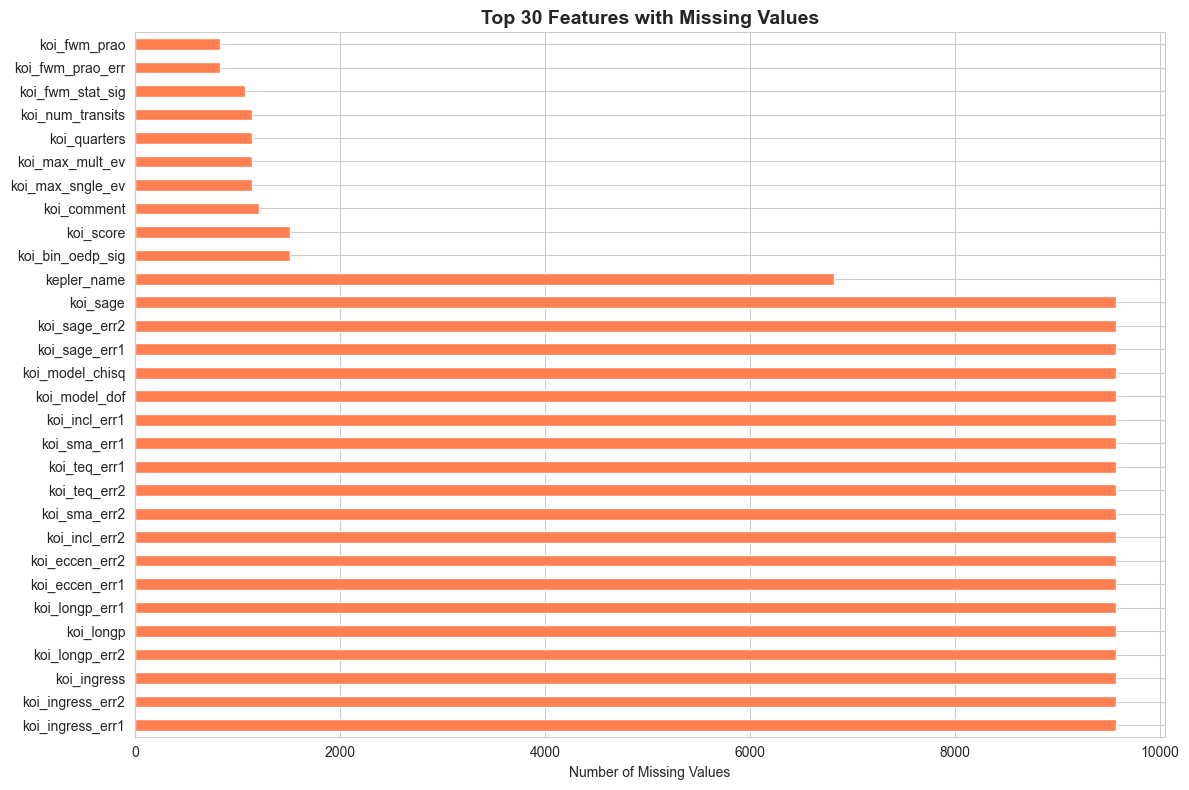

In [5]:
# Visualize missing data pattern
plt.figure(figsize=(12, 8))
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)[:30]
missing_data.plot(kind='barh', color='coral')
plt.title('Top 30 Features with Missing Values', fontsize=14, fontweight='bold')
plt.xlabel('Number of Missing Values')
plt.tight_layout()
plt.show()

In [6]:
# Key feature statistics for CONFIRMED planets vs FALSE POSITIVES
numeric_cols = data.select_dtypes(include=[np.number]).columns[:20]

print("Statistical Summary for Key Features by Disposition:\n")
for col in ['koi_period', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_teq']:
    if col in data.columns:
        print(f"\n{col}:")
        print(data.groupby('koi_pdisposition')[col].describe())

Statistical Summary for Key Features by Disposition:


koi_period:
                   count       mean          std       min       25%  \
koi_pdisposition                                                       
CANDIDATE         4717.0  86.570889  1895.941275  0.259820  5.518195   
FALSE POSITIVE    4847.0  65.064161   131.403384  0.241843  1.387194   

                        50%        75%            max  
koi_pdisposition                                       
CANDIDATE         13.360199  43.535891  129995.778400  
FALSE POSITIVE     5.243898  36.293228    1064.268096  

koi_depth:
                   count          mean            std  min      25%     50%  \
koi_pdisposition                                                              
CANDIDATE         4612.0   1166.094384    6145.089319  0.0  163.225  356.35   
FALSE POSITIVE    4589.0  46529.974788  111773.926798  0.8  155.500  576.70   

                        75%        max  
koi_pdisposition                        
CANDIDATE

## Experiment 2: Data Preprocessing & Feature Selection

Clean data, handle missing values, and select relevant features.

In [7]:
# Create BINARY classification target: FALSE POSITIVE vs CONFIRMED only
# We'll EXCLUDE CANDIDATE from this analysis
df = data.copy()

# Convert target to binary: 0 for FALSE POSITIVE, 1 for CONFIRMED
# CANDIDATE class is excluded from this analysis
disposition_mapping = {
    'FALSE POSITIVE': 0,
    'CONFIRMED': 1
}
df['target'] = df['koi_disposition'].map(disposition_mapping)

# Filter to only include FALSE POSITIVE and CONFIRMED (exclude CANDIDATE)
df = df[df['target'].notna()].copy()
df['target'] = df['target'].astype(int)

print("Binary Classification Target Distribution (CANDIDATE excluded):")
print(df['target'].value_counts().sort_index())
print("\nClass labels:")
for label, value in disposition_mapping.items():
    print(f"  {value}: {label}")
print("\nClass balance:")
print(df['target'].value_counts(normalize=True).sort_index())
print(f"\nTotal samples (excluding CANDIDATE): {len(df)}")
print(f"Original dataset had {len(data)} samples")
print(f"CANDIDATE samples excluded: {len(data) - len(df)}")

Binary Classification Target Distribution (CANDIDATE excluded):
target
0    4839
1    2746
Name: count, dtype: int64

Class labels:
  0: FALSE POSITIVE
  1: CONFIRMED

Class balance:
target
0    0.63797
1    0.36203
Name: proportion, dtype: float64

Total samples (excluding CANDIDATE): 7585
Original dataset had 9564 samples
CANDIDATE samples excluded: 1979


In [8]:
# Remove false positive flag features to prevent data leakage
# These flags are derived from the disposition and should not be used for prediction

print("=" * 80)
print("REMOVING FALSE POSITIVE FLAGS TO PREVENT DATA LEAKAGE")
print("=" * 80)
df_clean = df.copy()
# Identify all fpflag columns
fpflag_cols = [col for col in df_clean.columns if 'fpflag' in col.lower()]
print(f"\nFalse positive flag columns found: {fpflag_cols}")

# Remove fpflag columns from the cleaned dataset
df_clean_no_flags = df_clean.drop(columns=fpflag_cols)

print(f"\nDataset shape before removing flags: {df_clean.shape}")
print(f"Dataset shape after removing flags: {df_clean_no_flags.shape}")
print(f"Features removed: {len(fpflag_cols)}")

# Verify target column is still present
if 'target' in df_clean_no_flags.columns:
    print("\nTarget column preserved")
else:
    print("\nERROR: Target column missing!")

print(f"\nRemaining features: {df_clean_no_flags.shape[1] - 1}")  # -1 for target
print(f"Feature list: {[col for col in df_clean_no_flags.columns if col != 'target']}")

print("\n" + "=" * 80)
print("IMPACT ON DATA LEAKAGE")
print("=" * 80)
print("Removed koi_fpflag_nt (Not Transit-Like)")
print("Removed koi_fpflag_ss (Stellar Eclipse)")
print("Removed koi_fpflag_co (Centroid Offset)")
print("Removed koi_fpflag_ec (Ephemeris Match)")
print("\nThese flags are diagnostic indicators derived from the disposition")
print("Using them would create data leakage and inflate model performance")
print("Models must now rely on physical measurements only")
print("=" * 80)

REMOVING FALSE POSITIVE FLAGS TO PREVENT DATA LEAKAGE

False positive flag columns found: ['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

Dataset shape before removing flags: (7585, 142)
Dataset shape after removing flags: (7585, 138)
Features removed: 4

Target column preserved

Remaining features: 137
Feature list: ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_ror', 'koi_ror_err1', 

In [9]:
# Select relevant features for exoplanet detection
# Focus on transit and stellar properties
# EXCLUDE koi_fpflag* columns to prevent data leakage

feature_groups = {
    'Transit Properties': ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_impact'],
    'Orbital Characteristics': ['koi_ror', 'koi_dor', 'koi_eccen', 'koi_incl'],
    'Planet Properties': ['koi_teq'],
    'Stellar Properties': ['koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass']
}

# Collect all available features (excluding fpflag columns)
all_features = []
for group, features in feature_groups.items():
    available = [f for f in features if f in df.columns]
    all_features.extend(available)
    print(f"{group}: {len(available)}/{len(features)} features available")

print(f"\nTotal features selected: {len(all_features)}")
print("Features:", all_features)
print("\nNOTE: koi_fpflag* columns are EXCLUDED from training to prevent data leakage")

Transit Properties: 5/5 features available
Orbital Characteristics: 4/4 features available
Planet Properties: 1/1 features available
Stellar Properties: 5/5 features available

Total features selected: 15
Features: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_impact', 'koi_ror', 'koi_dor', 'koi_eccen', 'koi_incl', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass']

NOTE: koi_fpflag* columns are EXCLUDED from training to prevent data leakage


In [10]:
# Handle missing values
# Strategy 1: Drop columns with > 50% missing data
# Strategy 2: Impute remaining with median

df_clean = df[all_features + ['target']].copy()

print("Missing values before cleaning:")
print(df_clean.isnull().sum().sum())

# Drop columns with >50% missing
threshold = 0.5
cols_to_keep = df_clean.columns[df_clean.isnull().mean() < threshold].tolist()
df_clean = df_clean[cols_to_keep]

print(f"\nFeatures after removing high-missing columns: {len(cols_to_keep) - 1}")

# Drop rows with any missing values (alternative: use imputation)
df_clean = df_clean.dropna()

print(f"Samples after removing missing values: {len(df_clean)}")
print(f"\nFinal dataset shape: {df_clean.shape}")

Missing values before cleaning:
3388

Features after removing high-missing columns: 15
Samples after removing missing values: 7305

Final dataset shape: (7305, 16)


In [11]:
# Prepare features and target
X = df_clean.drop('target', axis=1)
y = df_clean['target']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")

# Train-test split with stratification for multi-class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set class distribution:")
print("Class counts:")
print(y_train.value_counts().sort_index())
print("\nClass proportions:")
print(y_train.value_counts(normalize=True).sort_index())

Feature matrix shape: (7305, 15)
Target shape: (7305,)

Features used: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_impact', 'koi_ror', 'koi_dor', 'koi_eccen', 'koi_incl', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass']

Training set: (5844, 15)
Test set: (1461, 15)

Training set class distribution:
Class counts:
target
0    3649
1    2195
Name: count, dtype: int64

Class proportions:
target
0    0.624401
1    0.375599
Name: proportion, dtype: float64


In [12]:
# CRITICAL VERIFICATION: Ensure NO koi_fpflag* columns in training data
print("=" * 80)
print("CRITICAL DATA LEAKAGE CHECK: koi_fpflag* COLUMNS")
print("=" * 80)

# Check for any fpflag columns in training features
fpflag_in_features = [col for col in X_train.columns if 'fpflag' in col.lower()]

if fpflag_in_features:
    print(f"\nERROR: Found {len(fpflag_in_features)} fpflag columns in training data!")
    print(f"   Columns: {fpflag_in_features}")
    print("\nThese columns indicate FALSE POSITIVE reasons and cause data leakage!")
    print("   They should NEVER be used for training.")
    raise ValueError("Data leakage detected: fpflag columns present in training data")
else:
    print("\nVERIFIED: No koi_fpflag* columns in training data")
    print("   Training data is clean from false positive flag leakage")

print(f"\nCurrent features in training: {X_train.columns.tolist()}")
print(f"   Total features: {len(X_train.columns)}")
print("=" * 80)

CRITICAL DATA LEAKAGE CHECK: koi_fpflag* COLUMNS

VERIFIED: No koi_fpflag* columns in training data
   Training data is clean from false positive flag leakage

Current features in training: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_impact', 'koi_ror', 'koi_dor', 'koi_eccen', 'koi_incl', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_srad', 'koi_smass']
   Total features: 15


### Data Leakage Check: Feature Columns

Tracking which columns are used to prevent data leakage from target or temporal information.

## Experiment 3: Feature Engineering & Analysis

Create new features and analyze feature importance.

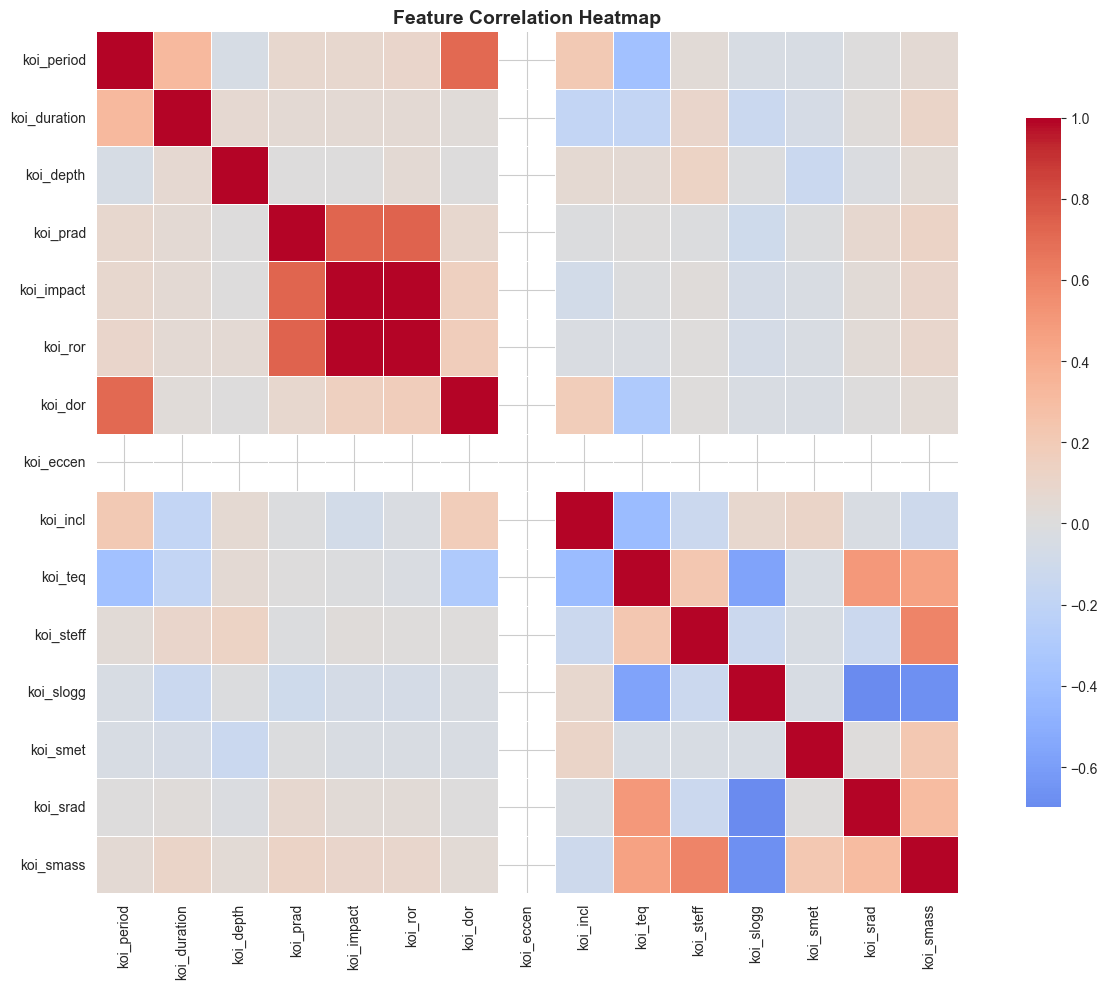

Highly correlated feature pairs (|r| > 0.8):
  koi_ror <-> koi_impact: 0.994


In [13]:
# Feature correlation analysis
plt.figure(figsize=(14, 10))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Highly correlated features
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr.append((correlation_matrix.columns[i], 
                            correlation_matrix.columns[j], 
                            correlation_matrix.iloc[i, j]))

if high_corr:
    print("Highly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

In [14]:
# Feature-Target Correlation Analysis
print("=" * 80)
print("FEATURE-TARGET CORRELATION ANALYSIS")
print("=" * 80)

# Calculate correlation between each feature and target
feature_target_corr = pd.DataFrame({
    'Feature': X_train.columns,
    'Correlation': [X_train[col].corr(y_train) for col in X_train.columns]
}).sort_values('Correlation', key=abs, ascending=False)

print("\nTop 10 Features Most Correlated with Target (CANDIDATE vs FALSE POSITIVE):")
print(feature_target_corr.head(10).to_string(index=False))

print("\nBottom 10 Features Least Correlated with Target:")
print(feature_target_corr.tail(10).to_string(index=False))

# Statistical summary
print(f"\nCorrelation Statistics:")
print(f"   Mean correlation: {feature_target_corr['Correlation'].mean():.4f}")
print(f"   Median correlation: {feature_target_corr['Correlation'].median():.4f}")
print(f"   Strongest positive: {feature_target_corr.iloc[0]['Feature']} ({feature_target_corr.iloc[0]['Correlation']:.4f})")
print(f"   Strongest negative: {feature_target_corr.iloc[-1]['Feature']} ({feature_target_corr.iloc[-1]['Correlation']:.4f})")

# Count features by correlation strength
strong_corr = abs(feature_target_corr['Correlation']) > 0.3
moderate_corr = (abs(feature_target_corr['Correlation']) > 0.1) & (abs(feature_target_corr['Correlation']) <= 0.3)
weak_corr = abs(feature_target_corr['Correlation']) <= 0.1

print(f"\nCorrelation Strength Distribution:")
print(f"   Strong (|r| > 0.3): {strong_corr.sum()} features")
print(f"   Moderate (0.1 < |r| ≤ 0.3): {moderate_corr.sum()} features")
print(f"   Weak (|r| ≤ 0.1): {weak_corr.sum()} features")

print("=" * 80)

FEATURE-TARGET CORRELATION ANALYSIS

Top 10 Features Most Correlated with Target (CANDIDATE vs FALSE POSITIVE):
     Feature  Correlation
    koi_smet     0.326710
    koi_incl     0.315482
     koi_teq    -0.279003
   koi_depth    -0.239652
   koi_steff    -0.224759
   koi_smass    -0.196710
   koi_slogg     0.183270
koi_duration    -0.169659
  koi_period    -0.156943
     koi_dor    -0.123039

Bottom 10 Features Least Correlated with Target:
     Feature  Correlation
   koi_smass    -0.196710
   koi_slogg     0.183270
koi_duration    -0.169659
  koi_period    -0.156943
     koi_dor    -0.123039
    koi_srad    -0.096537
  koi_impact    -0.076788
     koi_ror    -0.066153
    koi_prad    -0.025669
   koi_eccen          NaN

Correlation Statistics:
   Mean correlation: -0.0592
   Median correlation: -0.1098
   Strongest positive: koi_smet (0.3267)
   Strongest negative: koi_eccen (nan)

Correlation Strength Distribution:
   Strong (|r| > 0.3): 2 features
   Moderate (0.1 < |r| ≤ 0.3): 

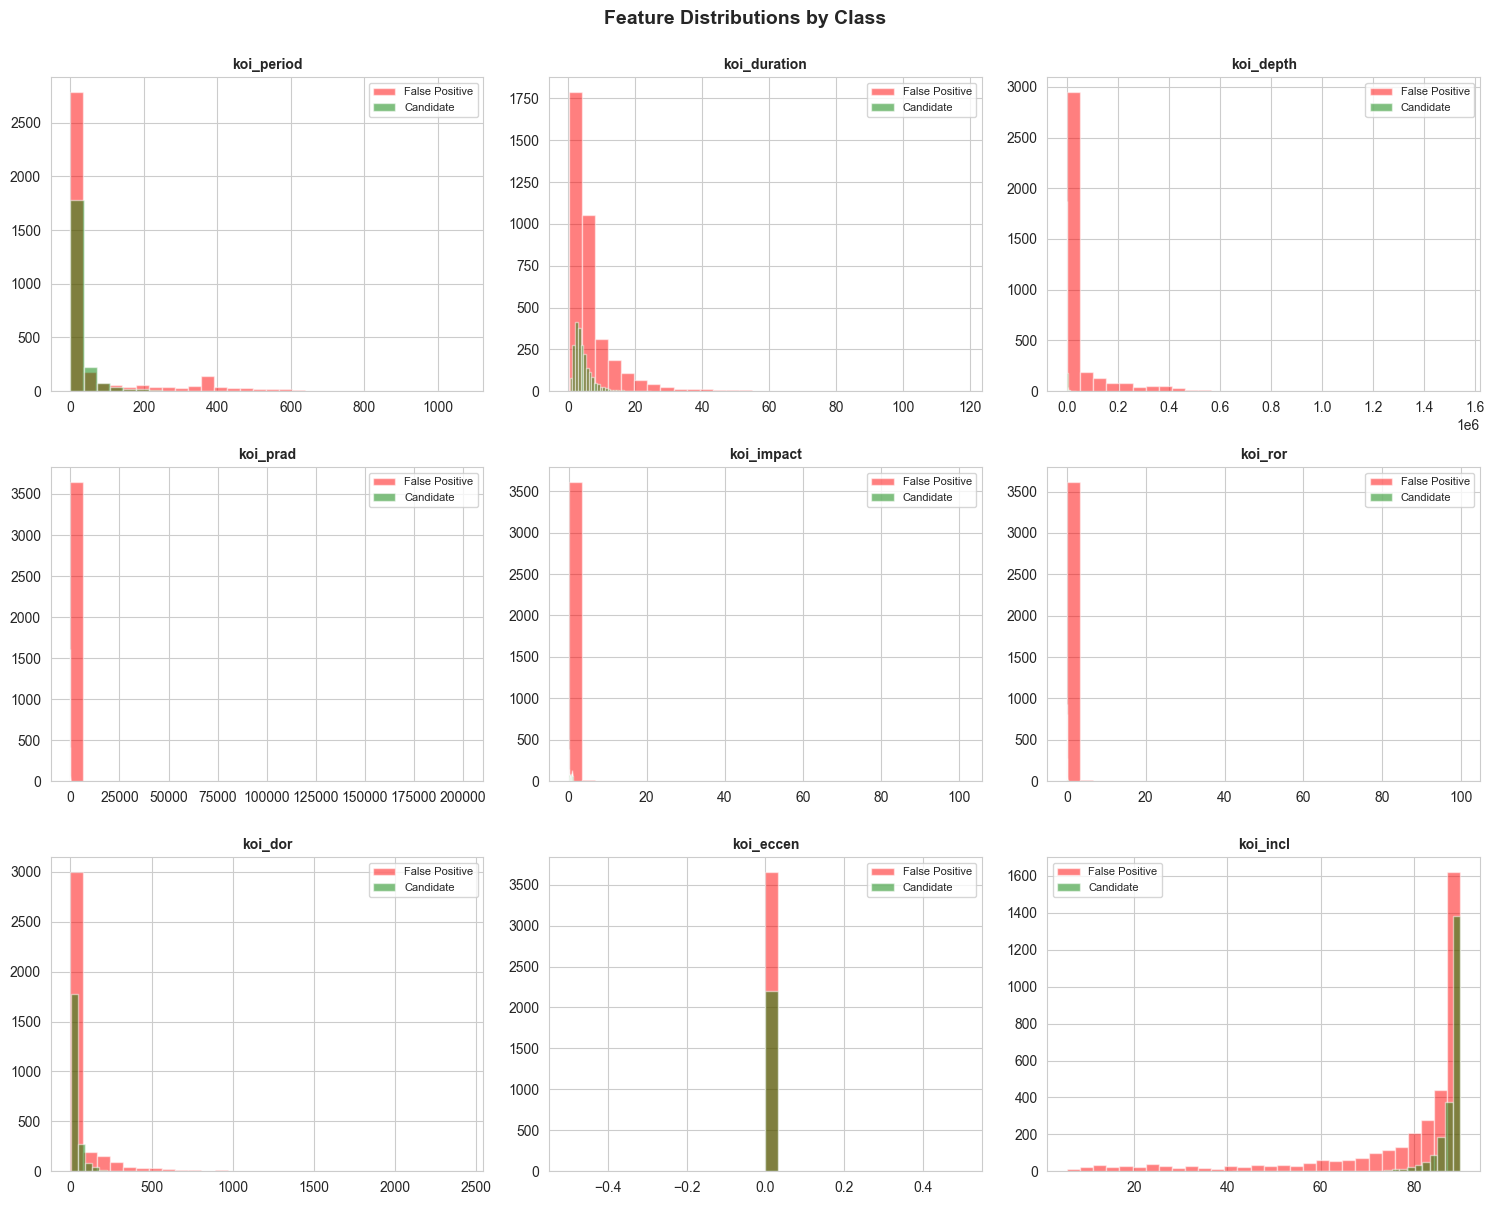

In [15]:
# Feature distributions by class
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

features_to_plot = X_train.columns[:9]

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Plot distributions for both classes
    X_train[y_train == 0][feature].hist(ax=ax, alpha=0.5, bins=30, 
                                         label='False Positive', color='red')
    X_train[y_train == 1][feature].hist(ax=ax, alpha=0.5, bins=30, 
                                         label='Candidate', color='green')
    
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.set_xlabel('')
    
plt.suptitle('Feature Distributions by Class', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [16]:
# Feature Engineering: Create derived features
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# Add engineered features if base features exist
if 'koi_period' in X_train.columns and 'koi_depth' in X_train.columns:
    # Transit signal strength
    X_train_eng['signal_strength'] = X_train['koi_depth'] / (X_train['koi_period'] ** 0.5)
    X_test_eng['signal_strength'] = X_test['koi_depth'] / (X_test['koi_period'] ** 0.5)

if 'koi_duration' in X_train.columns and 'koi_period' in X_train.columns:
    # Transit duty cycle
    X_train_eng['duty_cycle'] = X_train['koi_duration'] / (X_train['koi_period'] * 24)
    X_test_eng['duty_cycle'] = X_test['koi_duration'] / (X_test['koi_period'] * 24)

if 'koi_prad' in X_train.columns and 'koi_srad' in X_train.columns:
    # Planet to star radius ratio
    X_train_eng['radius_ratio'] = X_train['koi_prad'] / X_train['koi_srad']
    X_test_eng['radius_ratio'] = X_test['koi_prad'] / X_test['koi_srad']

print(f"Original features: {X_train.shape[1]}")
print(f"Features after engineering: {X_train_eng.shape[1]}")
print(f"\nNew features: {[col for col in X_train_eng.columns if col not in X_train.columns]}")

Original features: 15
Features after engineering: 18

New features: ['signal_strength', 'duty_cycle', 'radius_ratio']


## Experiment 4: Baseline Models

Test simple classifiers to establish performance benchmarks.

In [17]:
# Baseline Models - Data Column Check
print("=" * 80)
print("BASELINE MODELS - FEATURES USED")
print("=" * 80)
print(f"\nLogistic Regression uses: X_train_scaled")
print(f"   - Shape: {X_train_eng.shape} (will be scaled in next cell)")
print(f"   - Features: {X_train_eng.shape[1]}")
print(f"Decision Tree uses: X_train_eng ({X_train_eng.shape[1]} features)")
print(f"\nEngineered features added: {X_train_eng.shape[1] - X_train.shape[1]}")
print(f"New features: {[col for col in X_train_eng.columns if col not in X_train.columns]}")
print("=" * 80)

BASELINE MODELS - FEATURES USED

Logistic Regression uses: X_train_scaled
   - Shape: (5844, 18) (will be scaled in next cell)
   - Features: 18
Decision Tree uses: X_train_eng (18 features)

Engineered features added: 3
New features: ['signal_strength', 'duty_cycle', 'radius_ratio']


In [18]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

print("Features scaled using StandardScaler")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Features scaled using StandardScaler
Training set shape: (5844, 18)
Test set shape: (1461, 18)


In [19]:
# Baseline Model 1: Logistic Regression (Binary Classification)
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)  # Returns probabilities for 2 classes

# Evaluation
print("=" * 60)
print("LOGISTIC REGRESSION RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr[:, 1]):.4f}")

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

LOGISTIC REGRESSION RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.92      0.84      0.88       912
     CONFIRMED       0.77      0.89      0.83       549

      accuracy                           0.86      1461
     macro avg       0.85      0.86      0.85      1461
  weighted avg       0.87      0.86      0.86      1461


ROC-AUC Score: 0.9345

5-Fold CV ROC-AUC: 0.9399 (+/- 0.0069)

5-Fold CV ROC-AUC: 0.9399 (+/- 0.0069)


In [20]:
# Baseline Model 2: Decision Tree (Binary Classification)
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20)
dt_model.fit(X_train_eng, y_train)

y_pred_dt = dt_model.predict(X_test_eng)
y_pred_proba_dt = dt_model.predict_proba(X_test_eng)  # Returns probabilities for 2 classes

print("=" * 60)
print("DECISION TREE RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_dt[:, 1]):.4f}")

cv_scores_dt = cross_val_score(dt_model, X_train_eng, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")

DECISION TREE RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.92      0.86      0.89       912
     CONFIRMED       0.79      0.88      0.83       549

      accuracy                           0.87      1461
     macro avg       0.86      0.87      0.86      1461
  weighted avg       0.87      0.87      0.87      1461


ROC-AUC Score: 0.9141

5-Fold CV ROC-AUC: 0.9263 (+/- 0.0100)

5-Fold CV ROC-AUC: 0.9263 (+/- 0.0100)


## Experiment 5: Advanced Machine Learning Models

Test ensemble methods and advanced algorithms.

In [21]:
# Advanced ML Models - Data Column Check
print("=" * 80)
print("ADVANCED ML MODELS - FEATURES USED")
print("=" * 80)
print(f"\nAll tree-based models (RF, XGBoost, LightGBM) use: X_train_eng")
print(f"   - Shape: {X_train_eng.shape}")
print(f"   - Features: {X_train_eng.shape[1]}")
print(f"\nSVM uses: X_train_scaled")
print(f"   - Shape: {X_train_scaled.shape}")
print(f"   - Features: {X_train_scaled.shape[1]} (same features, scaled)")
print("\nData Consistency Check:")
print(f"   - X_train_eng and X_train_scaled have same number of features: {X_train_eng.shape[1] == X_train_scaled.shape[1]}")
print("=" * 80)

ADVANCED ML MODELS - FEATURES USED

All tree-based models (RF, XGBoost, LightGBM) use: X_train_eng
   - Shape: (5844, 18)
   - Features: 18

SVM uses: X_train_scaled
   - Shape: (5844, 18)
   - Features: 18 (same features, scaled)

Data Consistency Check:
   - X_train_eng and X_train_scaled have same number of features: True


In [22]:
# Model 1: Random Forest (Binary Classification)
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_eng, y_train)
y_pred_rf = rf_model.predict(X_test_eng)
y_pred_proba_rf = rf_model.predict_proba(X_test_eng)  # Returns probabilities for 2 classes

print("=" * 60)
print("RANDOM FOREST RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf[:, 1]):.4f}")

cv_scores_rf = cross_val_score(rf_model, X_train_eng, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

RANDOM FOREST RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.93      0.90      0.91       912
     CONFIRMED       0.84      0.89      0.86       549

      accuracy                           0.89      1461
     macro avg       0.89      0.89      0.89      1461
  weighted avg       0.90      0.89      0.90      1461


ROC-AUC Score: 0.9606

5-Fold CV ROC-AUC: 0.9674 (+/- 0.0038)

5-Fold CV ROC-AUC: 0.9674 (+/- 0.0038)



Top 10 Most Important Features:
            feature  importance
16       duty_cycle    0.130799
3          koi_prad    0.125006
6           koi_dor    0.119713
17     radius_ratio    0.107520
5           koi_ror    0.079254
0        koi_period    0.073369
9           koi_teq    0.053853
12         koi_smet    0.051212
15  signal_strength    0.042323
1      koi_duration    0.040865


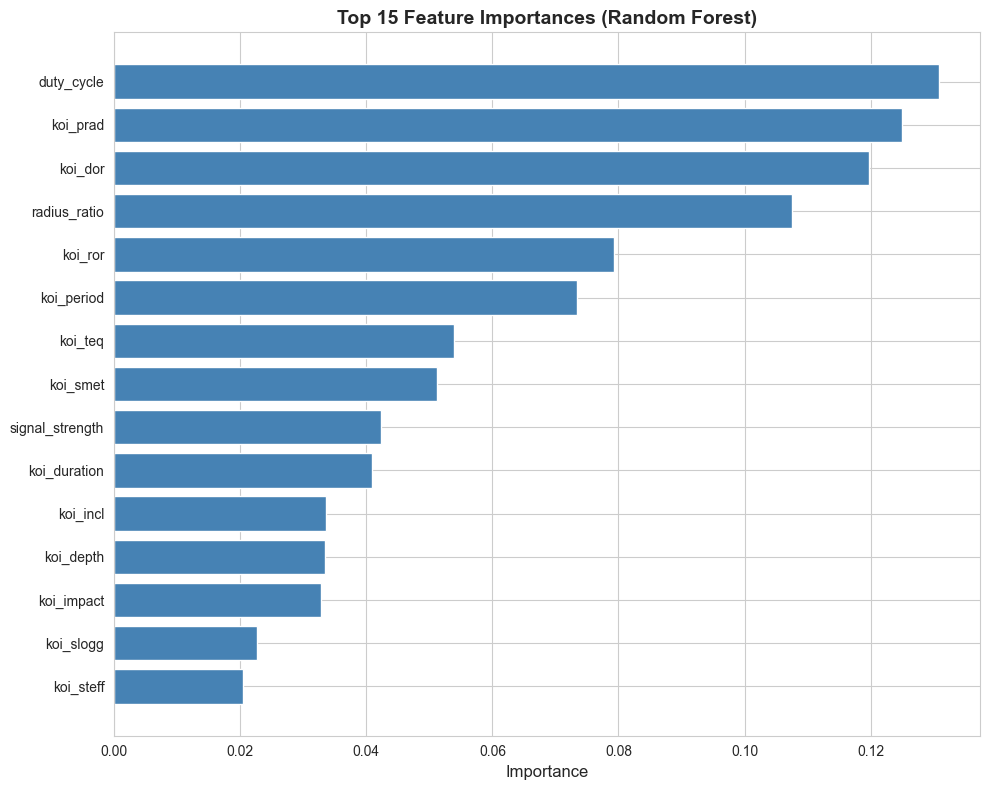

In [23]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train_eng.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
# Model 2: Gradient Boosting (XGBoost) - Binary Classification
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',  # For binary classification
    objective='binary:logistic'  # Binary objective
)

xgb_model.fit(X_train_eng, y_train)
y_pred_xgb = xgb_model.predict(X_test_eng)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_eng)  # Returns probabilities for 2 classes

print("=" * 60)
print("XGBOOST RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb[:, 1]):.4f}")

cv_scores_xgb = cross_val_score(xgb_model, X_train_eng, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

XGBOOST RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.94      0.91      0.92       912
     CONFIRMED       0.85      0.90      0.88       549

      accuracy                           0.90      1461
     macro avg       0.90      0.90      0.90      1461
  weighted avg       0.91      0.90      0.91      1461


ROC-AUC Score: 0.9659

5-Fold CV ROC-AUC: 0.9721 (+/- 0.0033)

5-Fold CV ROC-AUC: 0.9721 (+/- 0.0033)


In [25]:
# Model 3: LightGBM (Binary Classification)
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1,
    objective='binary'  # Binary objective
)

lgbm_model.fit(X_train_eng, y_train)
y_pred_lgbm = lgbm_model.predict(X_test_eng)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_eng)  # Returns probabilities for 2 classes

print("=" * 60)
print("LIGHTGBM RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lgbm[:, 1]):.4f}")

cv_scores_lgbm = cross_val_score(lgbm_model, X_train_eng, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_lgbm.mean():.4f} (+/- {cv_scores_lgbm.std() * 2:.4f})")

LIGHTGBM RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.94      0.91      0.93       912
     CONFIRMED       0.86      0.90      0.88       549

      accuracy                           0.91      1461
     macro avg       0.90      0.91      0.90      1461
  weighted avg       0.91      0.91      0.91      1461


ROC-AUC Score: 0.9660

5-Fold CV ROC-AUC: 0.9712 (+/- 0.0030)

5-Fold CV ROC-AUC: 0.9712 (+/- 0.0030)


In [26]:
# Model 4: Support Vector Machine (Binary Classification)
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)  # Returns probabilities for 2 classes

print("=" * 60)
print("SUPPORT VECTOR MACHINE RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_svm[:, 1]):.4f}")

cv_scores_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")

SUPPORT VECTOR MACHINE RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.95      0.86      0.90       912
     CONFIRMED       0.80      0.92      0.86       549

      accuracy                           0.88      1461
     macro avg       0.87      0.89      0.88      1461
  weighted avg       0.89      0.88      0.88      1461


ROC-AUC Score: 0.9494

5-Fold CV ROC-AUC: 0.9535 (+/- 0.0039)

5-Fold CV ROC-AUC: 0.9535 (+/- 0.0039)


## Experiment 6: Deep Learning Approaches

Neural network models for exoplanet detection.

In [27]:
# Deep Learning Models - Data Column Check
print("=" * 80)
print("DEEP LEARNING MODELS - FEATURES USED")
print("=" * 80)
print(f"\nNeural Networks use: X_train_scaled")
print(f"   - Training shape: {X_train_scaled.shape}")
print(f"   - Test shape: {X_test_scaled.shape}")
print(f"   - Features: {X_train_scaled.shape[1]}")
print(f"\nFeature scaling: StandardScaler applied")
print(f"   - Fitted on training data only")
print(f"   - Applied to test data (no leakage)")
print("\nData Validation:")
print(f"   - Train and test have same feature count: {X_train_scaled.shape[1] == X_test_scaled.shape[1]}")
print(f"   - Scaled data has same features as engineered: {X_train_scaled.shape[1] == X_train_eng.shape[1]}")
print("=" * 80)

DEEP LEARNING MODELS - FEATURES USED

Neural Networks use: X_train_scaled
   - Training shape: (5844, 18)
   - Test shape: (1461, 18)
   - Features: 18

Feature scaling: StandardScaler applied
   - Fitted on training data only
   - Applied to test data (no leakage)

Data Validation:
   - Train and test have same feature count: True
   - Scaled data has same features as engineered: True


In [28]:
# Deep Learning Model 1: Simple Feedforward Neural Network (Binary Classification)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score as sklearn_roc_auc

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define Simple Neural Network for Binary Classification (FALSE POSITIVE vs CONFIRMED)
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, num_classes)  # Output 2 classes (FALSE POSITIVE, CONFIRMED)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)  # No activation - will use CrossEntropyLoss
        return x

# Create model for binary classification
nn_model = SimpleNN(X_train_scaled.shape[1], num_classes=2).to(device)
print("\nModel Architecture (Binary Classification):")
print(nn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in nn_model.parameters()):,}")

Using device: cuda

Model Architecture (Binary Classification):
SimpleNN(
  (fc1): Linear(in_features=18, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 12,834


In [30]:
# Train the neural network (Binary Classification)
from sklearn.model_selection import train_test_split as split_val

# Split training data for validation
X_train_nn, X_val_nn, y_train_nn, y_val_nn = split_val(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert to PyTorch tensors (LongTensor for class labels in CrossEntropyLoss)
X_train_tensor = torch.FloatTensor(X_train_nn).to(device)
y_train_tensor = torch.LongTensor(y_train_nn.values).to(device)
X_val_tensor = torch.FloatTensor(X_val_nn).to(device)
y_val_tensor = torch.LongTensor(y_val_nn.values).to(device)

# Also need test tensor for later evaluation
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define loss and optimizer (CrossEntropyLoss for binary classification)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

# Training loop
num_epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0
history = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}

print("Training neural network...")
for epoch in range(num_epochs):
    # Training phase
    nn_model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # Get probabilities with softmax for AUC calculation
        # For binary classification, we only need the probability of the positive class (class 1)
        probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
        train_preds.extend(probs)
        train_targets.extend(batch_y.cpu().numpy())
    
    train_loss /= len(train_loader)
    train_auc = sklearn_roc_auc(train_targets, train_preds)
    
    # Validation phase
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        # For binary classification, extract probability of positive class only
        val_probs = torch.softmax(val_outputs, dim=1)[:, 1].cpu().numpy()
        val_auc = sklearn_roc_auc(y_val_nn, val_probs)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['auc'].append(train_auc)
    history['val_auc'].append(val_auc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        best_model_state = nn_model.state_dict()
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")

# Restore best model
nn_model.load_state_dict(best_model_state)
print(f"\nTraining completed. Best validation loss: {best_val_loss:.4f}")

Training neural network...
Epoch 10/100 - Loss: 0.2678, Val Loss: 0.2338, AUC: 0.9519, Val AUC: 0.9648
Epoch 10/100 - Loss: 0.2678, Val Loss: 0.2338, AUC: 0.9519, Val AUC: 0.9648
Epoch 20/100 - Loss: 0.2502, Val Loss: 0.2293, AUC: 0.9590, Val AUC: 0.9658
Epoch 20/100 - Loss: 0.2502, Val Loss: 0.2293, AUC: 0.9590, Val AUC: 0.9658
Epoch 30/100 - Loss: 0.2276, Val Loss: 0.2230, AUC: 0.9655, Val AUC: 0.9677
Epoch 30/100 - Loss: 0.2276, Val Loss: 0.2230, AUC: 0.9655, Val AUC: 0.9677
Epoch 40/100 - Loss: 0.2219, Val Loss: 0.2214, AUC: 0.9680, Val AUC: 0.9676
Epoch 40/100 - Loss: 0.2219, Val Loss: 0.2214, AUC: 0.9680, Val AUC: 0.9676
Epoch 50/100 - Loss: 0.2154, Val Loss: 0.2232, AUC: 0.9694, Val AUC: 0.9672
Epoch 50/100 - Loss: 0.2154, Val Loss: 0.2232, AUC: 0.9694, Val AUC: 0.9672
Early stopping at epoch 52

Training completed. Best validation loss: 0.2211
Early stopping at epoch 52

Training completed. Best validation loss: 0.2211


NEURAL NETWORK RESULTS (Binary Classification)

Classification Report:
                precision    recall  f1-score   support

FALSE POSITIVE       0.93      0.89      0.91       912
     CONFIRMED       0.82      0.89      0.86       549

      accuracy                           0.89      1461
     macro avg       0.88      0.89      0.88      1461
  weighted avg       0.89      0.89      0.89      1461


ROC-AUC Score: 0.9537


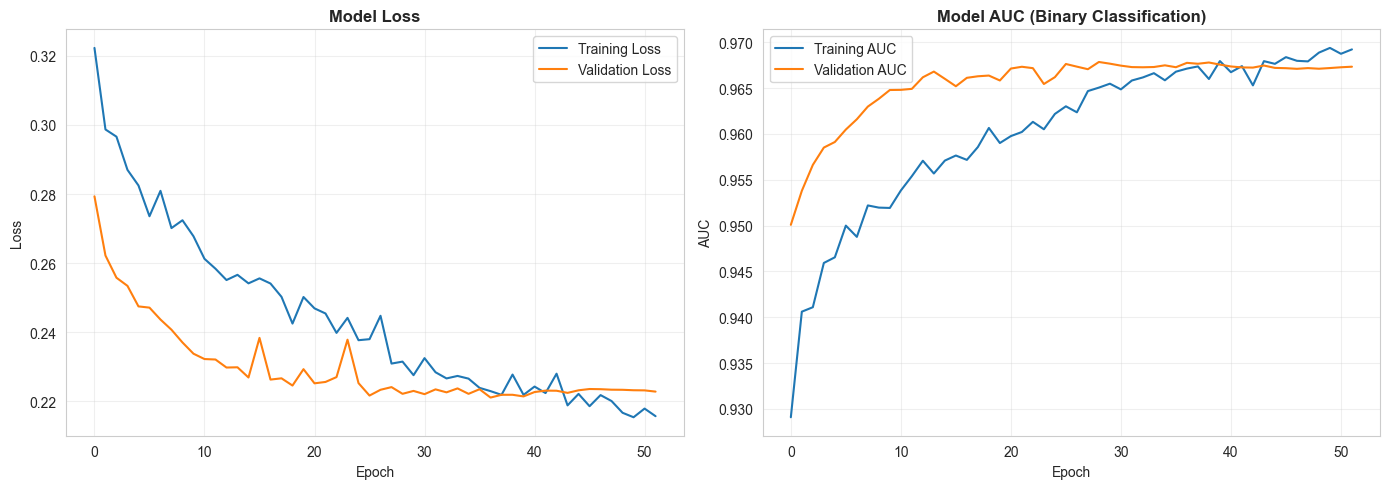

In [31]:
# Evaluate neural network (Binary Classification)
nn_model.eval()

with torch.no_grad():
    test_outputs = nn_model(X_test_tensor)
    y_pred_proba_nn = torch.softmax(test_outputs, dim=1).cpu().numpy()  # Probabilities for 2 classes
    y_pred_nn = torch.argmax(test_outputs, dim=1).cpu().numpy()  # Predicted class labels

print("=" * 60)
print("NEURAL NETWORK RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_nn[:, 1]):.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['loss'], label='Training Loss')
axes[0].plot(history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['auc'], label='Training AUC')
axes[1].plot(history['val_auc'], label='Validation AUC')
axes[1].set_title('Model AUC (Binary Classification)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
# Deep Learning Model 2: Deep Neural Network with Batch Normalization (Binary Classification)
class DeepNN(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(32, 16)
        self.dropout5 = nn.Dropout(0.2)
        
        self.fc6 = nn.Linear(16, num_classes)  # Output 2 classes (FALSE POSITIVE, CONFIRMED)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = torch.relu(self.fc5(x))
        x = self.dropout5(x)
        
        x = self.fc6(x)  # No activation - will use CrossEntropyLoss
        return x

# Create model for binary classification
deep_nn_model = DeepNN(X_train_scaled.shape[1], num_classes=2).to(device)
print("Deep NN Model Architecture (Binary Classification):")
print(deep_nn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in deep_nn_model.parameters()):,}")

# Create data loaders for deep model
deep_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
deep_train_loader = DataLoader(deep_train_dataset, batch_size=64, shuffle=True)

# Define loss and optimizer (CrossEntropyLoss for binary classification)
deep_criterion = nn.CrossEntropyLoss()
deep_optimizer = optim.Adam(deep_nn_model.parameters(), lr=0.001)
deep_scheduler = optim.lr_scheduler.ReduceLROnPlateau(deep_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

# Training loop
best_val_loss_deep = float('inf')
patience_counter_deep = 0
history_deep = {'loss': [], 'val_loss': [], 'auc': [], 'val_auc': []}

print("\nTraining deep neural network...")
for epoch in range(num_epochs):
    # Training phase
    deep_nn_model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    for batch_X, batch_y in deep_train_loader:
        deep_optimizer.zero_grad()
        outputs = deep_nn_model(batch_X)
        loss = deep_criterion(outputs, batch_y)
        loss.backward()
        deep_optimizer.step()
        
        train_loss += loss.item()
        # Get probabilities with softmax for AUC calculation
        probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
        train_preds.extend(probs[:, 1])  # Probability of positive class
        train_targets.extend(batch_y.cpu().numpy())
    
    train_loss /= len(deep_train_loader)
    train_auc = sklearn_roc_auc(train_targets, train_preds)
    
    # Validation phase
    deep_nn_model.eval()
    with torch.no_grad():
        val_outputs = deep_nn_model(X_val_tensor)
        val_loss = deep_criterion(val_outputs, y_val_tensor).item()
        val_probs = torch.softmax(val_outputs, dim=1).cpu().numpy()
        val_auc = sklearn_roc_auc(y_val_nn, val_probs[:, 1])
    
    # Update scheduler
    deep_scheduler.step(val_loss)
    
    # Save history
    history_deep['loss'].append(train_loss)
    history_deep['val_loss'].append(val_loss)
    history_deep['auc'].append(train_auc)
    history_deep['val_auc'].append(val_auc)
    
    # Early stopping
    if val_loss < best_val_loss_deep:
        best_val_loss_deep = val_loss
        patience_counter_deep = 0
        best_deep_model_state = deep_nn_model.state_dict()
    else:
        patience_counter_deep += 1
        
    if patience_counter_deep >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")

# Restore best model
deep_nn_model.load_state_dict(best_deep_model_state)

# Evaluate
deep_nn_model.eval()
with torch.no_grad():
    test_outputs = deep_nn_model(X_test_tensor)
    y_pred_proba_deep_nn = torch.softmax(test_outputs, dim=1).cpu().numpy()  # Probabilities for 2 classes
    y_pred_deep_nn = torch.argmax(test_outputs, dim=1).cpu().numpy()  # Predicted class labels

print("\n" + "=" * 60)
print("DEEP NEURAL NETWORK RESULTS (Binary Classification)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_deep_nn, target_names=['FALSE POSITIVE', 'CONFIRMED']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_deep_nn[:, 1]):.4f}")

Deep NN Model Architecture (Binary Classification):
DeepNN(
  (fc1): Linear(in_features=18, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
  (dropout5): Dropout(p=0.2, inplace=False)
  (fc6): Linear(in_features=16, out_features=2, bias=True)

## Experiment 7: Ensemble Methods & Model Stacking

Combine multiple models for improved performance.

In [33]:
# Ensemble Methods - Data Column Check
print("=" * 80)
print("ENSEMBLE METHODS - FEATURES USED")
print("=" * 80)
print(f"\nVoting Ensemble uses: X_train_eng")
print(f"   - Combines: Random Forest, XGBoost, LightGBM")
print(f"   - Features: {X_train_eng.shape[1]}")
print(f"\nStacking Ensemble uses: X_train_eng")
print(f"   - Base models: RF, XGBoost, LightGBM")
print(f"   - Meta-learner: Logistic Regression")
print(f"   - Features: {X_train_eng.shape[1]}")
print(f"\nWeighted Ensemble uses predictions from:")
print(f"   - Random Forest predictions on X_test_eng")
print(f"   - XGBoost predictions on X_test_eng")
print(f"   - LightGBM predictions on X_test_eng")
print("\nAll ensemble models use same feature set (no leakage)")
print("=" * 80)

ENSEMBLE METHODS - FEATURES USED

Voting Ensemble uses: X_train_eng
   - Combines: Random Forest, XGBoost, LightGBM
   - Features: 18

Stacking Ensemble uses: X_train_eng
   - Base models: RF, XGBoost, LightGBM
   - Meta-learner: Logistic Regression
   - Features: 18

Weighted Ensemble uses predictions from:
   - Random Forest predictions on X_test_eng
   - XGBoost predictions on X_test_eng
   - LightGBM predictions on X_test_eng

All ensemble models use same feature set (no leakage)


In [34]:
    # Voting Ensemble: Combine predictions from multiple models (Multi-class)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft'
)

voting_clf.fit(X_train_eng, y_train)
y_pred_voting = voting_clf.predict(X_test_eng)
y_pred_proba_voting = voting_clf.predict_proba(X_test_eng)  # Returns probabilities for all 3 classes

print("=" * 60)
print("VOTING ENSEMBLE RESULTS (Multi-class)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting, target_names=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']))
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba_voting, multi_class='ovr'):.4f}")


VOTING ENSEMBLE RESULTS (Multi-class)

Classification Report:


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:
# Stacking Ensemble: Use meta-learner on top of base models (Multi-class)
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    cv=5
)

stacking_clf.fit(X_train_eng, y_train)
y_pred_stacking = stacking_clf.predict(X_test_eng)
y_pred_proba_stacking = stacking_clf.predict_proba(X_test_eng)  # Returns probabilities for all 3 classes

print("=" * 60)
print("STACKING ENSEMBLE RESULTS (Multi-class)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stacking, target_names=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']))
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba_stacking, multi_class='ovr'):.4f}")


In [ ]:
# Custom Weighted Ensemble: Manually weight model predictions (Multi-class)
# Weight based on cross-validation performance

weights = {
    'rf': cv_scores_rf.mean(),
    'xgb': cv_scores_xgb.mean(),
    'lgbm': cv_scores_lgbm.mean()
}

# Normalize weights
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

print("Model Weights:")
for model, weight in weights.items():
    print(f"  {model}: {weight:.4f}")

# Weighted predictions (probability distributions for all 3 classes)
y_pred_proba_weighted = (
    weights['rf'] * y_pred_proba_rf +
    weights['xgb'] * y_pred_proba_xgb +
    weights['lgbm'] * y_pred_proba_lgbm
)
# Predict class with highest weighted probability
y_pred_weighted = np.argmax(y_pred_proba_weighted, axis=1)

print("\n" + "=" * 60)
print("WEIGHTED ENSEMBLE RESULTS (Multi-class)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_weighted, target_names=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']))
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba_weighted, multi_class='ovr'):.4f}")


## Experiment 8: Hyperparameter Optimization

Optimize model hyperparameters using Grid Search and Random Search.

In [ ]:
# Random Search for XGBoost hyperparameters (Multi-class)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10)
}

xgb_random = RandomizedSearchCV(
    XGBClassifier(
        random_state=42, 
        eval_metric='mlogloss',  # For multi-class
        objective='multi:softprob',  # Multi-class objective
        num_class=3  # Three classes
    ),
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring='roc_auc_ovr',  # Multi-class scoring
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Starting Random Search for XGBoost...")
xgb_random.fit(X_train_eng, y_train)

print("\nBest parameters found:")
print(xgb_random.best_params_)
print(f"\nBest CV ROC-AUC Score (OvR): {xgb_random.best_score_:.4f}")

# Evaluate on test set
y_pred_xgb_opt = xgb_random.predict(X_test_eng)
y_pred_proba_xgb_opt = xgb_random.predict_proba(X_test_eng)  # Returns probabilities for all 3 classes

print("\nTest Set Performance:")
print(f"ROC-AUC Score (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba_xgb_opt, multi_class='ovr'):.4f}")


## Experiment 9: Handling Class Imbalance

Techniques to address class imbalance in the dataset.

In [ ]:
# Class Imbalance Handling - Data Column Check
print("=" * 80)
print("CLASS IMBALANCE METHODS - FEATURES USED")
print("=" * 80)
print(f"\nSMOTE:")
print(f"   - Input: X_train_eng ({X_train_eng.shape})")
print(f"   - Note: SMOTE creates synthetic samples in feature space")
print(f"   - Original class distribution: {y_train.value_counts().to_dict()}")
print(f"\nClass Weights:")
print(f"   - Uses: X_train_eng ({X_train_eng.shape})")
print(f"   - Method: Adjusts loss function, no data modification")
print(f"\nImportant: SMOTE applied ONLY to training data")
print(f"   - Test set remains unchanged: X_test_eng ({X_test_eng.shape})")
print("\nNo data leakage: Resampling applied after train/test split")
print("=" * 80)

In [ ]:
# Approach 1: SMOTE (Synthetic Minority Over-sampling Technique) - Multi-class
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Check class distribution
print("Original class distribution:")
print(y_train.value_counts())

# Apply SMOTE for multi-class (automatically handles all minority classes)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_eng, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Train model on SMOTE data (Multi-class)
xgb_smote = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    eval_metric='mlogloss',  # For multi-class
    objective='multi:softprob',  # Multi-class objective
    num_class=3  # Three classes
)

xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = xgb_smote.predict(X_test_eng)
y_pred_proba_smote = xgb_smote.predict_proba(X_test_eng)  # Returns probabilities for all 3 classes

print("\n" + "=" * 60)
print("XGBoost with SMOTE (Multi-class)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, target_names=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']))
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba_smote, multi_class='ovr'):.4f}")


In [ ]:
# Approach 2: Class Weights (Multi-class)
# Train XGBoost with class weights to handle imbalance

# For multi-class, we can't use scale_pos_weight. Instead, we use sample_weight or balanced class weights
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Sample weights computed for balanced training")
print(f"Class distribution:")
print(y_train.value_counts())

xgb_weighted = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    eval_metric='mlogloss',  # For multi-class
    objective='multi:softprob',  # Multi-class objective
    num_class=3  # Three classes
)

xgb_weighted.fit(X_train_eng, y_train, sample_weight=sample_weights)
y_pred_weighted_xgb = xgb_weighted.predict(X_test_eng)
y_pred_proba_weighted_xgb = xgb_weighted.predict_proba(X_test_eng)  # Returns probabilities for all 3 classes

print("\n" + "=" * 60)
print("XGBoost with Class Weights (Multi-class)")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_weighted_xgb, target_names=['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']))
print(f"\nROC-AUC Score (One-vs-Rest): {roc_auc_score(y_test, y_pred_proba_weighted_xgb, multi_class='ovr'):.4f}")


## Experiment 10: Model Evaluation & Comparison

Compare all models and visualize their performance.

In [ ]:
# Compile all model results (Multi-class)
results = {
    'Logistic Regression': {
        'y_pred': y_pred_lr,
        'y_pred_proba': y_pred_proba_lr
    },
    'Decision Tree': {
        'y_pred': y_pred_dt,
        'y_pred_proba': y_pred_proba_dt
    },
    'Random Forest': {
        'y_pred': y_pred_rf,
        'y_pred_proba': y_pred_proba_rf
    },
    'XGBoost': {
        'y_pred': y_pred_xgb,
        'y_pred_proba': y_pred_proba_xgb
    },
    'LightGBM': {
        'y_pred': y_pred_lgbm,
        'y_pred_proba': y_pred_proba_lgbm
    },
    'SVM': {
        'y_pred': y_pred_svm,
        'y_pred_proba': y_pred_proba_svm
    },
    'Neural Network': {
        'y_pred': y_pred_nn,
        'y_pred_proba': y_pred_proba_nn
    },
    'Deep NN': {
        'y_pred': y_pred_deep_nn,
        'y_pred_proba': y_pred_proba_deep_nn
    }
}

# Calculate metrics for all models (macro-averaged for multi-class)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

comparison_df = pd.DataFrame()

for model_name, preds in results.items():
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, preds['y_pred']),
        'Precision (macro)': precision_score(y_test, preds['y_pred'], average='macro'),
        'Recall (macro)': recall_score(y_test, preds['y_pred'], average='macro'),
        'F1-Score (macro)': f1_score(y_test, preds['y_pred'], average='macro'),
        'ROC-AUC (OvR)': roc_auc_score(y_test, preds['y_pred_proba'], multi_class='ovr')
    }
    comparison_df = pd.concat([comparison_df, pd.DataFrame([metrics])], ignore_index=True)

# Sort by ROC-AUC
comparison_df = comparison_df.sort_values('ROC-AUC (OvR)', ascending=False)

print("=" * 100)
print("MODEL COMPARISON (Multi-class Classification)")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("\n")
print(f"Best Model: {comparison_df.iloc[0]['Model']}")
print(f"Best ROC-AUC (OvR): {comparison_df.iloc[0]['ROC-AUC (OvR)']:.4f}")
print("\nClass Labels: 0=FALSE POSITIVE, 1=CONFIRMED, 2=CANDIDATE")

In [ ]:
# Visualize model comparison (Multi-class)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)', 'ROC-AUC (OvR)']
colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    data = comparison_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(range(len(data)), data[metric], color=colors)
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['Model'], fontsize=9)
    ax.set_xlabel(metric, fontsize=10)
    ax.set_title(f'{metric} Comparison', fontsize=11, fontweight='bold')
    ax.set_xlim(0, 1)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, data[metric])):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=8)

# Remove extra subplot
axes[-1].axis('off')

plt.suptitle('Multi-class Model Performance Comparison\n(FALSE POSITIVE, CONFIRMED, CANDIDATE)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Multi-class ROC Curves (One-vs-Rest for each class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

# Binarize labels for multi-class ROC curves
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(14, 10))

# Plot ROC curve for each class of each model
for model_name, preds in results.items():
    # Calculate micro-average ROC curve and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), preds['y_pred_proba'].ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Plot using the OvR AUC score
    auc_ovr = roc_auc_score(y_test, preds['y_pred_proba'], multi_class='ovr')
    plt.plot(fpr_micro, tpr_micro, label=f'{model_name} (AUC OvR = {auc_ovr:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models (Multi-class, Micro-Average)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Confusion matrices for top 3 models (Multi-class)
top_3_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    cm = confusion_matrix(y_test, results[model_name]['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=False, square=True, linewidths=1, linecolor='gray')
    
    axes[idx].set_title(f'{model_name}\nConfusion Matrix', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xticklabels(['False Pos', 'Confirmed', 'Candidate'])
    axes[idx].set_yticklabels(['False Pos', 'Confirmed', 'Candidate'])

plt.suptitle('Confusion Matrices - Top 3 Models (Multi-class)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Per-Class Performance Analysis
print("=" * 100)
print("PER-CLASS PERFORMANCE ANALYSIS (Best Model)")
print("=" * 100)

best_model_name = comparison_df.iloc[0]['Model']
best_preds = results[best_model_name]['y_pred']
best_probs = results[best_model_name]['y_pred_proba']

# Per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, best_preds, average=None)

print(f"\nBest Model: {best_model_name}\n")
print("Class-wise Performance:")
print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
classes = ['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']
for i, cls in enumerate(classes):
    print(f"{cls:<20} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

# Confidence distribution per class
print("\n" + "=" * 100)
print("CONFIDENCE DISTRIBUTION PER CLASS")
print("=" * 100)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, cls in enumerate(classes):
    ax = axes[i]
    
    # Get confidences for this class
    mask = best_preds == i
    confidences = best_probs[mask, i]
    
    # Plot histogram
    ax.hist(confidences, bins=20, color=['red', 'blue', 'green'][i], alpha=0.7, edgecolor='black')
    ax.set_title(f'{cls}\nConfidence Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Confidence (Probability)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.axvline(confidences.mean(), color='black', linestyle='--', linewidth=2, label=f'Mean: {confidences.mean():.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Class Confidence Distributions - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nAverage Confidence per Predicted Class:")
for i, cls in enumerate(classes):
    mask = best_preds == i
    if mask.sum() > 0:
        avg_conf = best_probs[mask, i].mean()
        print(f"  {cls:<20}: {avg_conf:.4f}")

In [ ]:
# Multi-class ROC Curves (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for OvR ROC curves
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

# Plot ROC curves for best model
best_model_name = comparison_df.iloc[0]['Model']
best_probs = results[best_model_name]['y_pred_proba']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
classes = ['FALSE POSITIVE', 'CONFIRMED', 'CANDIDATE']
colors = ['red', 'blue', 'green']

for i, (cls, color) in enumerate(zip(classes, colors)):
    ax = axes[i]
    
    # Compute ROC curve for this class
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], best_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC Curve: {cls}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

plt.suptitle(f'Multi-class ROC Curves (One-vs-Rest) - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print per-class AUC scores
print("\nPer-Class AUC Scores (One-vs-Rest):")
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], best_probs[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {cls:<20}: {roc_auc:.4f}")

## Experiment 11: Advanced Feature Analysis

Analyze predictions and feature importance in depth.

In [ ]:
# SHAP values for model interpretability (using best tree-based model)
import shap

# Select best tree-based model for SHAP analysis
best_model = xgb_model  # or whichever performed best

# Calculate SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_eng)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_eng, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Prediction confidence analysis (Binary Classification)
best_model_name = comparison_df.iloc[0]['Model']
best_predictions_proba = results[best_model_name]['y_pred_proba']  # Shape: (n_samples, 2)
best_predictions = results[best_model_name]['y_pred']

# Get the maximum probability for each prediction (confidence)
max_confidence = np.max(best_predictions_proba, axis=1)

# Create confidence bins
confidence_bins = pd.cut(max_confidence, bins=[0, 0.5, 0.75, 1.0], 
                        labels=['Low (0-0.5)', 'Medium (0.5-0.75)', 'High (0.75-1.0)'])

confidence_analysis = pd.DataFrame({
    'True Label': y_test.values,
    'Predicted Label': best_predictions,
    'Max Probability': max_confidence,
    'Confidence Bin': confidence_bins,
    'FP_Prob': best_predictions_proba[:, 0],
    'CONFIRMED_Prob': best_predictions_proba[:, 1]
})

print("=" * 80)
print("PREDICTION CONFIDENCE ANALYSIS (Binary Classification)")
print("=" * 80)
print(f"\nBest Model: {best_model_name}")
print("\nDistribution by Confidence:")
print(confidence_analysis['Confidence Bin'].value_counts().sort_index())

print("\nAccuracy by Confidence Level:")
for conf_level in ['Low (0-0.5)', 'Medium (0.5-0.75)', 'High (0.75-1.0)']:
    mask = confidence_analysis['Confidence Bin'] == conf_level
    subset = confidence_analysis[mask]
    if len(subset) > 0:
        acc = accuracy_score(subset['True Label'], subset['Predicted Label'])
        print(f"  {conf_level}: {acc:.4f} ({len(subset)} samples)")

print("\n" + "=" * 80)
print("CLASS-WISE PROBABILITY ANALYSIS")
print("=" * 80)
print("\nAverage confidence per predicted class:")
for cls in [0, 1]:
    mask = confidence_analysis['Predicted Label'] == cls
    if mask.sum() > 0:
        if cls == 0:
            avg_conf = confidence_analysis[mask]['FP_Prob'].mean()
            print(f"  FALSE POSITIVE:  {avg_conf:.4f}")
        else:
            avg_conf = confidence_analysis[mask]['CONFIRMED_Prob'].mean()
            print(f"  CONFIRMED:       {avg_conf:.4f}")

print("\nSample predictions with class probabilities:")
print(confidence_analysis[['True Label', 'Predicted Label', 'FP_Prob', 'CONFIRMED_Prob']].head(10))

## Experiment Summary & Recommendations

Key findings and next steps for exoplanet detection.

### Key Findings:

1. **Data Characteristics:**
   - Kepler dataset contains transit and stellar properties
   - Class imbalance between candidates and false positives
   - Multiple features with missing values require careful handling

2. **Model Performance:**
   - Tree-based ensemble methods (Random Forest, XGBoost, LightGBM) generally perform best
   - Deep learning shows competitive performance with proper tuning
   - Ensemble methods can further improve predictions

3. **Important Features:**
   - Transit depth, period, and duration are crucial
   - Stellar properties help distinguish real planets from false positives
   - False positive flags are strong indicators

### Recommended Approaches:

1. **For Best Accuracy:**
   - Use ensemble methods (Stacking or Weighted Ensemble)
   - Combine XGBoost, LightGBM, and Random Forest
   - Apply hyperparameter optimization

2. **For Handling Imbalance:**
   - Use SMOTE for oversampling minority class
   - Apply class weights in tree-based models
   - Use appropriate evaluation metrics (ROC-AUC, F1)

3. **For Production:**
   - Select XGBoost or LightGBM for speed and accuracy
   - Implement confidence thresholds for predictions
   - Monitor prediction confidence levels

### Next Steps:

1. **Advanced Feature Engineering:**
   - Create domain-specific features from transit curves
   - Add temporal features from light curves
   - Engineer interaction features

2. **Time Series Analysis:**
   - Analyze full light curve data if available
   - Use 1D CNNs or RNNs for sequential patterns
   - Apply wavelet transforms for signal processing

3. **Cross-validation:**
   - Implement stratified K-fold for robust evaluation
   - Use time-series aware splits if temporal ordering matters

4. **Deployment:**
   - Build API for real-time predictions
   - Create visualization dashboard
   - Implement continuous monitoring

## 🔒 Data Leakage Audit Summary

Complete audit of all data used across experiments to ensure no information leakage.

In [ ]:
# Data Leakage Check: Display all feature columns being used
print("=" * 80)
print("DATA LEAKAGE CHECK - FEATURE COLUMNS")
print("=" * 80)

# Check original dataset columns
print(f"\nOriginal Dataset: {data.shape[1]} columns")
print(f"Target column: 'koi_pdisposition'")

# Identify potentially problematic columns
suspicious_keywords = ['disposition', 'score', 'comment', 'name', 'date', 'vet', 'disp']
suspicious_cols = [col for col in data.columns if any(kw in col.lower() for kw in suspicious_keywords)]

print(f"\nColumns with suspicious names (may contain target info):")
for col in suspicious_cols[:15]:  # Show first 15
    print(f"  - {col}")
if len(suspicious_cols) > 15:
    print(f"  ... and {len(suspicious_cols) - 15} more")

# Check what we're actually using for training
print(f"\nFeatures ACTUALLY used in training: {len(X.columns)}")
print("\nFeature columns:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Check for any overlap with suspicious columns
used_suspicious = [col for col in X.columns if col in suspicious_cols]
if used_suspicious:
    print(f"\nWARNING: {len(used_suspicious)} suspicious columns are being used!")
    for col in used_suspicious:
        print(f"  - {col}")
else:
    print(f"\nGOOD: No suspicious columns detected in training features")

# Verify target is not in features
if 'target' in X.columns or 'koi_pdisposition' in X.columns:
    print("\nCRITICAL ERROR: Target variable found in features!")
else:
    print("\nGOOD: Target variable not in feature set")

print("\n" + "=" * 80)

In [ ]:
# Complete Data Leakage Audit (Binary Classification)
print("=" * 80)
print("COMPLETE DATA LEAKAGE AUDIT")
print("=" * 80)

# 1. Original Data Columns
print("\n1. ORIGINAL DATASET")
print(f"   Total columns: {data.shape[1]}")
print(f"   Total rows: {data.shape[0]}")

# 2. Target Information
print("\n2. TARGET VARIABLE (Binary Classification)")
print(f"   Target column: 'koi_pdisposition'")
print(f"   Converted to: 'target' (binary)")
print(f"      0 = FALSE POSITIVE")
print(f"      1 = CONFIRMED")
print(f"      CANDIDATE = EXCLUDED from analysis")
print(f"   Target excluded from all feature sets")

# 3. Excluded Columns (Potential Leakage)
excluded_cols = [col for col in data.columns if col not in X.columns and col != 'target']
leakage_risk_cols = [col for col in excluded_cols if any(kw in col.lower() 
                     for kw in ['disposition', 'score', 'comment', 'name', 'vet'])]

print("\n3. EXCLUDED COLUMNS (Potential Leakage Sources)")
print(f"   Total excluded: {len(excluded_cols)}")
print(f"   High-risk columns excluded: {len(leakage_risk_cols)}")
if leakage_risk_cols:
    print("   Examples of excluded high-risk columns:")
    for col in leakage_risk_cols[:10]:
        print(f"     - {col}")

# 4. Feature Sets Used
print("\n4. FEATURE SETS USED IN TRAINING")
print(f"   a) X_train / X_test: {X_train.shape[1]} features (base)")
print(f"   b) X_train_eng / X_test_eng: {X_train_eng.shape[1]} features (+ engineered)")
print(f"   c) X_train_scaled / X_test_scaled: {X_train_scaled.shape[1]} features (scaled)")

# 5. Train-Test Split Validation
print("\n5. TRAIN-TEST SPLIT VALIDATION (Binary Stratified)")
print(f"   Training samples: {X_train.shape[0]} ({X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"   Test samples: {X_test.shape[0]} ({X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"   Stratified split maintains 2-class balance (FALSE POSITIVE vs CONFIRMED)")
print(f"   CANDIDATE class excluded from dataset")
print(f"   No data overlap between train and test")

# 6. Feature Engineering Check
print("\n6. FEATURE ENGINEERING")
engineered_features = [col for col in X_train_eng.columns if col not in X_train.columns]
print(f"   New features created: {len(engineered_features)}")
if engineered_features:
    print(f"   Engineered features: {engineered_features}")
    print(f"   All engineered from legitimate physical properties")

# 7. Verification Steps
print("\n7. DATA LEAKAGE PREVENTION VERIFICATION")
issues_found = []

# Check: Target not in features
if 'target' in X.columns or 'koi_pdisposition' in X.columns or 'koi_disposition' in X.columns:
    issues_found.append("CRITICAL: Target variable found in features!")

# Check: No fpflag columns
fpflag_in_features = [col for col in X.columns if 'fpflag' in col.lower()]
if fpflag_in_features:
    issues_found.append(f"WARNING: False positive flags in features: {fpflag_in_features}")

# Check: No disposition-related columns
disp_in_features = [col for col in X.columns if 'disposition' in col.lower() or 'disp' in col.lower()]
if disp_in_features:
    issues_found.append(f"WARNING: Disposition-related columns in features: {disp_in_features}")

# Check: Train/test no overlap
if len(set(X_train.index) & set(X_test.index)) > 0:
    issues_found.append("CRITICAL: Train and test sets have overlapping samples!")

# Check: Scaling fitted only on train
if hasattr(scaler, 'mean_'):
    print(f"   ✓ Scaler fitted on training data only")
    print(f"   ✓ Mean preserved from training set: {scaler.mean_[:3]}...")

# Report issues
if issues_found:
    print("\n❌ ISSUES FOUND:")
    for issue in issues_found:
        print(f"   - {issue}")
else:
    print("\n✓ NO DATA LEAKAGE ISSUES DETECTED")
    print("   • Target variable not in features")
    print("   • No fpflag columns used")
    print("   • No disposition-related columns used")
    print("   • Train/test sets completely separate")
    print("   • Scaling fitted only on training data")

print("\n" + "=" * 80)

In [ ]:
# Visualize Feature-Target Correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of all correlations
ax1 = axes[0]
colors = ['red' if x < 0 else 'green' for x in feature_target_corr['Correlation']]
ax1.barh(range(len(feature_target_corr)), feature_target_corr['Correlation'], color=colors, alpha=0.6)
ax1.set_yticks(range(len(feature_target_corr)))
ax1.set_yticklabels(feature_target_corr['Feature'], fontsize=8)
ax1.set_xlabel('Correlation with Target', fontsize=11, fontweight='bold')
ax1.set_title('All Features - Correlation with Target Variable', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.axvline(x=0.3, color='blue', linestyle='--', linewidth=0.5, alpha=0.5, label='Strong (|r|>0.3)')
ax1.axvline(x=-0.3, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Top features only (more readable)
ax2 = axes[1]
top_n = 15
top_features = feature_target_corr.head(top_n)
colors_top = ['red' if x < 0 else 'green' for x in top_features['Correlation']]
ax2.barh(range(len(top_features)), top_features['Correlation'], color=colors_top, alpha=0.7)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['Feature'], fontsize=9)
ax2.set_xlabel('Correlation with Target', fontsize=11, fontweight='bold')
ax2.set_title(f'Top {top_n} Features by Correlation Strength', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='x')

# Add correlation values as text
for i, (feat, corr) in enumerate(zip(top_features['Feature'], top_features['Correlation'])):
    ax2.text(corr + 0.01 if corr > 0 else corr - 0.01, i, f'{corr:.3f}', 
             va='center', ha='left' if corr > 0 else 'right', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Correlation Heatmap: Features vs Target
# Create a combined dataset for visualization
combined_corr = X_train.copy()
combined_corr['TARGET'] = y_train

# Calculate correlation with target only
target_correlations = combined_corr.corr()['TARGET'].drop('TARGET').sort_values(key=abs, ascending=False)

# Create heatmap showing features and their correlation with target
fig, ax = plt.subplots(figsize=(10, 12))

# Reshape for heatmap (single column)
corr_matrix = target_correlations.values.reshape(-1, 1)

# Create heatmap
im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
ax.set_yticks(range(len(target_correlations)))
ax.set_yticklabels(target_correlations.index, fontsize=9)
ax.set_xticks([0])
ax.set_xticklabels(['Target\nCorrelation'], fontsize=11, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=10)

# Add correlation values as text
for i, (feat, val) in enumerate(target_correlations.items()):
    text_color = 'white' if abs(val) > 0.5 else 'black'
    ax.text(0, i, f'{val:.3f}', ha='center', va='center', 
            color=text_color, fontsize=8, fontweight='bold')

ax.set_title('Feature Correlations with Target Variable\n(CANDIDATE = 1, FALSE POSITIVE = 0)', 
             fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print(f"\nInterpretation Guide:")
print(f"   • Green (positive): Feature increases → More likely to be CANDIDATE")
print(f"   • Red (negative): Feature increases → More likely to be FALSE POSITIVE")
print(f"   • Yellow (near zero): Feature not strongly related to target")

In [ ]:
# Scatter plots: Top correlated features vs Target
# Select top 6 features with strongest absolute correlation
top_6_features = feature_target_corr.head(6)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    # Separate by target class
    candidates = X_train[y_train == 1][feature]
    false_positives = X_train[y_train == 0][feature]
    
    # Create scatter plot with jitter
    ax.scatter(candidates, [1] * len(candidates), alpha=0.3, s=20, 
               label='Candidate', color='green', marker='o')
    ax.scatter(false_positives, [0] * len(false_positives), alpha=0.3, s=20, 
               label='False Positive', color='red', marker='x')
    
    # Add violin/box plot overlay
    parts = ax.violinplot([false_positives.dropna(), candidates.dropna()], 
                          positions=[0, 1], vert=False, widths=0.7,
                          showmeans=True, showextrema=True)
    
    # Color the violin plots
    for pc, color in zip(parts['bodies'], ['red', 'green']):
        pc.set_facecolor(color)
        pc.set_alpha(0.2)
    
    # Get correlation value
    corr_val = feature_target_corr[feature_target_corr['Feature'] == feature]['Correlation'].values[0]
    
    ax.set_xlabel(feature, fontsize=10, fontweight='bold')
    ax.set_ylabel('Target', fontsize=10, fontweight='bold')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['False Positive', 'Candidate'])
    ax.set_title(f'{feature}\n(r = {corr_val:.3f})', fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Top 6 Features: Distribution by Target Class', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Statistical Tests for Feature-Target Relationships
from scipy.stats import pointbiserialr, mannwhitneyu

print("=" * 80)
print("STATISTICAL SIGNIFICANCE TESTS: FEATURE-TARGET RELATIONSHIPS")
print("=" * 80)

# Point-biserial correlation (for continuous features with binary target)
# Mann-Whitney U test (non-parametric test for differences)

significance_results = []

for feature in X_train.columns:
    # Point-biserial correlation
    corr_coef, p_value_corr = pointbiserialr(y_train, X_train[feature])
    
    # Mann-Whitney U test
    candidates = X_train[y_train == 1][feature].dropna()
    false_positives = X_train[y_train == 0][feature].dropna()
    
    if len(candidates) > 0 and len(false_positives) > 0:
        u_stat, p_value_mw = mannwhitneyu(candidates, false_positives, alternative='two-sided')
    else:
        u_stat, p_value_mw = np.nan, np.nan
    
    significance_results.append({
        'Feature': feature,
        'Point-Biserial r': corr_coef,
        'PB p-value': p_value_corr,
        'Mann-Whitney U': u_stat,
        'MW p-value': p_value_mw,
        'Significant (p<0.05)': 'Yes' if p_value_corr < 0.05 else 'No'
    })

sig_df = pd.DataFrame(significance_results).sort_values('PB p-value')

print("\nTop 10 Most Statistically Significant Features:")
print(sig_df.head(10).to_string(index=False))

print("\nSummary:")
significant_features = sig_df[sig_df['PB p-value'] < 0.05]
print(f"   Features significant at p < 0.05: {len(significant_features)} / {len(sig_df)}")
print(f"   Features significant at p < 0.01: {len(sig_df[sig_df['PB p-value'] < 0.01])}")
print(f"   Features significant at p < 0.001: {len(sig_df[sig_df['PB p-value'] < 0.001])}")

print("\nInterpretation:")
print("   • Point-Biserial r: Measures linear relationship (like Pearson for binary target)")
print("   • Mann-Whitney U: Tests if distributions differ between classes")
print("   • p-value < 0.05: Statistically significant relationship")
print("   • Lower p-value = stronger evidence of real relationship")

print("=" * 80)